## Urban Expansion in Nairobi, Kenya 
Yujin Song, Lu Yii Wong

### 1. Problem Statement
Urban sprawl in Nairobi has led to inefficient infrastructure, increased transportation costs, and environmental degradation. Traditional monitoring methods, such as census and survey data, are often outdated and lack spatial detail. A remote sensing-based approach can provide timely, scalable insights into urban expansion. 

Nairobi is East Africa’s fastest-growing city, with a population that  surged from 290,000 in 1960 to over 5 million in 2023. This rapid growth has fueled unregulated expansion, particularly in informal settlements like Kibera and Korogocho, exacerbating land tenure issues and inadequate public services, such as water and electricity access. Effective planning requires a data-driven approach to monitoring and managing urban growth.

### 2. Target User

Our project is designed for Nairobi’s stakeholders and planning agencies responsible for infrastructure, land use, and public services. These stakeholders require spatially detailed, up-to-date insights to guide decision-making in informal settlement management, infrastructure investment, and environmental monitoring.

### 3. Methodology
For this project, we acquire satellite images at 5-year intervals to track changes in land use and land cover over time. We started our study in 1984, using Landsat 5 images to give us a good understanding of historical land use change during a period of rapid population growth in Nairobi.

We selected three key years for manual labeling based on Landsat sensor generations and trained machine learning models accordingly to classify land use across all years from 1984 to 2023.


### 4. Data Sources

We used Landsat satellite imagery obtained from Google Earth Engine to monitor land use change in Nairobi from 1984 to 2023. Images were selected at approximately 5-year intervals, filtered for cloud cover, and clipped to the Nairobi region boundary.

| Year | Landsat Sensor | Dataset ID                      |
|------|----------------|----------------------------------|
| 1984 | Landsat 5       | LANDSAT/LT05/C02/T1_L2          |
| 1994 | Landsat 5       | LANDSAT/LT05/C02/T1_L2          |
| 1999 | Landsat 7       | LANDSAT/LE07/C02/T1_L2          |
| 2004 | Landsat 7       | LANDSAT/LE07/C02/T1_L2          |
| 2009 | Landsat 7       | LANDSAT/LE07/C02/T1_L2          |
| 2014 | Landsat 8       | LANDSAT/LC08/C02/T1_L2          |
| 2019 | Landsat 8       | LANDSAT/LC08/C02/T1_L2          |
| 2023 | Landsat 8       | LANDSAT/LC08/C02/T1_L2          |

**Note on Data Availability**  
We were unable to obtain usable imagery for 1989 due to persistent cloud cover and data quality limitations in the Landsat 5 archive. For 1994 and 1999, we relaxed the cloud cover threshold (up to 30%) and expanded the date range to ensure that valid composites could be generated. These fallback adjustments allowed us to preserve temporal consistency while accounting for gaps in imagery availability.

#### 4.1 Pulling Landsat Data

In [ ]:
import ee
ee.Initialize()

# Define Nairobi bounding box
nairobi = ee.Geometry.Rectangle([36.6, -1.5, 37.1, -1.1])

# Function to get Landsat image composite by year and sensor
def get_landsat_composite_all_bands(year):
    start = f'{year}-01-01'
    end = f'{year}-12-31'
    
    if year >= 2014:
        collection_id = 'LANDSAT/LC08/C02/T1_L2'
    elif year >= 2004:
        collection_id = 'LANDSAT/LE07/C02/T1_L2'
    else:
        collection_id = 'LANDSAT/LT05/C02/T1_L2'

    collection = ee.ImageCollection(collection_id) \
        .filterBounds(nairobi) \
        .filterDate(start, end) \
        .filter(ee.Filter.lt('CLOUD_COVER', 10))
    
    # Apply scaling to SR bands only, leave QA/thermal untouched
    def scale_sr(img):
        sr_bands = img.select(img.bandNames().filter(ee.Filter.stringContains('item', 'SR_')))
        scaled = sr_bands.multiply(0.0000275).add(-0.2)
        others = img.select(img.bandNames().removeAll(sr_bands.bandNames()))
        return scaled.addBands(others).copyProperties(img, img.propertyNames())
    
    processed = collection.map(scale_sr)
    return processed.median().clip(nairobi)

# List of years to export
years = [1984, 1989, 1994, 1999, 2004, 2009, 2014, 2019, 2023]

# Loop and export images
tasks = []
for year in years:
    image = get_landsat_composite_all_bands(year)
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=f'Nairobi_Landsat_{year}_AllBands',
        folder='earthengine',
        fileNamePrefix=f'nairobi_landsat_{year}_allbands',
        region=nairobi,
        scale=30,
        maxPixels=1e13
    )
    task.start()
    tasks.append((year, task))

# Optional: print task status
for year, task in tasks:
    print(f"Export task for {year}: {task.status()['state']}")

In [ ]:
import ee
ee.Initialize()

# Define Nairobi bounding box
nairobi = ee.Geometry.Rectangle([36.6, -1.5, 37.1, -1.1])

# Fallback configuration for the two exportable years
fallback_config = {
    1994: {
        'collection_id': 'LANDSAT/LT05/C02/T1_L2',
        'start': '1993-01-01',
        'end': '1995-12-31',
    },
    1999: {
        'collection_id': 'LANDSAT/LE07/C02/T1_L2',
        'start': '1999-05-01',
        'end': '1999-12-31',
    },
}

for year, config in fallback_config.items():
    collection = ee.ImageCollection(config['collection_id']) \
        .filterBounds(nairobi) \
        .filterDate(config['start'], config['end']) \
        .filter(ee.Filter.lt('CLOUD_COVER', 30))

    count = collection.size().getInfo()

    if count > 0:
        print(f"🛰️ Exporting fallback for {year} with {count} images")

        def scale_sr(img):
            sr_bands = img.select(img.bandNames().filter(ee.Filter.stringContains('item', 'SR_')))
            scaled = sr_bands.multiply(0.0000275).add(-0.2)
            others = img.select(img.bandNames().removeAll(sr_bands.bandNames()))
            return scaled.addBands(others).copyProperties(img, img.propertyNames())

        image = collection.map(scale_sr).median().clip(nairobi)

        task = ee.batch.Export.image.toDrive(
            image=image,
            description=f'Nairobi_Landsat_{year}_fallback_allbands',
            folder='earthengine',
            fileNamePrefix=f'nairobi_landsat_{year}_fallback_allbands',
            region=nairobi,
            scale=30,
            maxPixels=1e13
        )
        task.start()
    else:
        print(f"⚠️ No valid images found for {year}. Skipping export.")

# Manual skip message for 1989
print("⚠️ Skipping 1989 fallback: No usable Landsat 5 imagery found for 1988–1990, even with relaxed filters.")

### 5. Labeling Process and Ground Truths

To generate training data, we manually labeled satellite imagery using **ArcGIS Pro**. Labels were assigned at the pixel level by visually interpreting Landsat images, referencing road patterns, building density, and Google Maps overlays.

We created ground truth labels for three key years:
- **1984** (Landsat 5)
- **2009** (Landsat 7)
- **2019** (Landsat 8)

For each year, we labeled approximately 900 training points across three land use categories:
- 0: Vegetation
- 1: Informal settlement
- 2: Formal settlement

To guide labeling and ensure spatial accuracy, we used known settlement areas in Nairobi as ground truth anchors.

**Informal Settlements Used for Reference:**
| Settlement | Approximate Establishment | Key Growth Period |
|------------|----------------------------|-------------------|
| Kibera     | 1904s                      | 1960s–1990s        |
| Mathare    | 1920s–1930s                 | 1950s–1970s        |
| Korogocho  | 1970s                      | 1980s–1990s        |
| Mukuru Kwa Njenga | 1980s                | 1990s–2000s        |

**Formal Settlements Used for Reference:**
| Settlement | Approximate Establishment | Key Growth Period |
|------------|----------------------------|-------------------|
| Starehe    | 1900s                      | 1960s–1990s        |
| Westlands  | 1920s–1930s                 | 1950s–1970s        |
| Lang’ata   | 1970s                      | 1980s–1990s        |
| Kasarani   | 1980s                      | 1990s–2000s        |

While we took care to align our labels with visible features- block patterns, access roads, and consistent building density, we acknowledge the challenges of interpreting informal vs. formal areas purely through satellite imagery.

### 6. Training and Classification

In [2]:
# Load Libraries 
import geopandas as gpd
import pandas as pd

In [3]:
# Load shapefiles
formal_gdf = gpd.read_file("landuse_class/formal.shp")
informal_gdf = gpd.read_file("landuse_class/informal.shp")
vegetation_gdf = gpd.read_file("landuse_class/vegetation.shp")

# Drop 'Id' columns in formal and vegetation
formal_gdf = formal_gdf.drop(columns=["Id"], errors='ignore')
vegetation_gdf = vegetation_gdf.drop(columns=["Id"], errors='ignore')

# Combine all into a single GeoDataFrame
combined_gdf = pd.concat([formal_gdf, informal_gdf, vegetation_gdf], ignore_index=True)

# Check the result (total of 900 points per lu class)
print(combined_gdf.head())
print(combined_gdf["landuse"].value_counts())

  landuse  database                   geometry
0  formal      1984  POINT (36.81875 -1.28296)
1  formal      1984  POINT (36.82147 -1.28555)
2  formal      1984  POINT (36.82169 -1.28429)
3  formal      1984  POINT (36.82322 -1.28458)
4  formal      1984  POINT (36.81933 -1.28491)
landuse
formal        900
informal      900
vegetation    900
Name: count, dtype: int64


In [4]:
# Check Projection
print(combined_gdf.crs)

EPSG:4326


#### 6.1 Load Landsat TIF files

We downloaded preprocessed multi-band Landsat `.tif` images for 1984, 2009, and 2019 using public Dropbox links. These images were exported from Google Earth Engine and include reflectance bands clipped to the Nairobi boundary. The script below automatically downloads the files and saves them to a local directory.

Each file corresponds to one labeled year and is used to train a classification model for its associated Landsat sensor.

In [5]:
import requests
import os 

In [6]:
# Create new output folder 
output_dir = "landsat_images"
os.makedirs(output_dir, exist_ok=True)

# Download multiple files
landsat_files = {
    "1984": "https://www.dropbox.com/scl/fi/nk6xavounp62ua13knj8z/nairobi_landsat_1984_allbands.tif?rlkey=1hy39oiei4fwcsahydg007n6s&st=smighyej&dl=1",
    "2009": "https://www.dropbox.com/scl/fi/flagfp77yvcyxt0b7plyj/nairobi_landsat_2009_allbands.tif?rlkey=etoqn6whwlkkz08cis68oyp6q&st=gpi4nlk5&dl=1",
    "2019": "https://www.dropbox.com/scl/fi/l09necnzqgyigbd13iddp/nairobi_landsat_2019_allbands.tif?rlkey=0gec6urstoqomk6141f2ag5re&st=4h1715d2&dl=1"
}

for year, url in landsat_files.items():
    output_path = os.path.join(output_dir, f"landsat_{year}.tif")
    r = requests.get(url)
    with open(output_path, 'wb') as f:
        f.write(r.content)
    print(f"Downloaded landsat_{year}.tif to {output_path}")


Downloaded landsat_1984.tif to landsat_images\landsat_1984.tif
Downloaded landsat_2009.tif to landsat_images\landsat_2009.tif
Downloaded landsat_2019.tif to landsat_images\landsat_2019.tif


#### 6.2 Preprocessing

Before training the classification model, we prepare the Landsat imagery by loading each `.tif` file using the `rasterio` library. This includes checking the coordinate reference system (CRS) to ensure spatial consistency across all images and shapefiles.

The Landsat files are multi-band raster images containing surface reflectance values for each band. These bands will be used as features for model training.
The code below imports required libraries, loads the 1984 image, and prints the CRS to confirm the image is projected correctly. All imagery in this project uses the same CRS to allow spatial alignment with training labels and output classifications.

In [7]:
# Load Libraries
import rasterio
import rasterio.mask
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from shapely.geometry import mapping
from shapely.geometry import box

In [8]:
# Check Projection
landsat_1984 = "landsat_images/landsat_1984.tif"

# Open the image and print its CRS
with rasterio.open(landsat_1984) as src:
    print("CRS:", src.crs)

CRS: EPSG:4326


#### 6.3 Split Training Data by Year

We split the labeled training data by year (1984, 2009, 2019), corresponding to each Landsat sensor generation. The `classify_year()` function takes in the raster image and training labels, trains a Random Forest model, classifies the entire image, and exports the results as a `.tif` file.

This step ensures that each model is trained on consistent sensor data before applying it to other years within the same Landsat group.

In [9]:
# Create Geodataframes with the labeled data by year
gdf_1984 = combined_gdf[combined_gdf['database'] == 1984]
gdf_2009 = combined_gdf[combined_gdf['database'] == 2009]
gdf_2019 = combined_gdf[combined_gdf['database'] == 2019]

In [26]:
# Classifier function

def classify_year(year, gdf, tif_path, out_path):
    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    # Open raster
    with rasterio.open(tif_path) as src:
        image = src.read()  # (bands, rows, cols)
        transform = src.transform
        raster_crs = src.crs
        raster_bounds = src.bounds
        meta = src.meta.copy()
        _, n_rows, n_cols = image.shape

    # Reproject training points to match raster
    if gdf.crs != raster_crs:
        gdf = gdf.to_crs(raster_crs)

    # Filter training points to those within raster extent
    raster_geom = box(*raster_bounds)
    gdf = gdf[gdf.geometry.within(raster_geom)]
    print(f"[{year}] Points after spatial filter: {len(gdf)}")

    if len(gdf) == 0:
        raise ValueError(f"No valid training points within raster bounds for year {year}.")

    # Extract coordinates and labels
    coords = [(geom.x, geom.y) for geom in gdf.geometry]
    labels = gdf['landuse'].astype('category').cat.codes.values

    # Convert coordinates to row/col pixel positions
    rows_cols = [~transform * (x, y) for x, y in coords]
    rows, cols = zip(*rows_cols)
    rows = np.array(rows)
    cols = np.array(cols)

    # Filter NaNs
    valid = (~np.isnan(rows)) & (~np.isnan(cols))
    rows = rows[valid].astype(int)
    cols = cols[valid].astype(int)
    labels = labels[valid]

    # Filter to points within raster dimensions
    in_bounds = (rows >= 0) & (rows < n_rows) & (cols >= 0) & (cols < n_cols)
    rows = rows[in_bounds]
    cols = cols[in_bounds]
    labels = labels[in_bounds]

    print(f"[{year}] Training samples used: {len(labels)}")

    # Extract pixel values for training
    samples = image[:, rows, cols].T  # shape: (samples, bands)

    # Train Random Forest model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(samples, labels)

    # Classify entire raster
    reshaped_img = image.reshape(image.shape[0], -1).T
    predictions = clf.predict(reshaped_img)
    classified = predictions.reshape((n_rows, n_cols))

    # Save output raster
    meta.update({"count": 1, "dtype": 'int16'})
    with rasterio.open(out_path, "w", **meta) as dest:
        dest.write(classified.astype('int16'), 1)

    print(f"[{year}] Classification complete. Saved to {out_path}")

    return clf, samples, labels


In [27]:
clf_1984, samples_1984, labels_1984 = classify_year(
    year='1984',
    gdf=gdf_1984,
    tif_path='landsat_images/landsat_1984.tif',
    out_path='classified_outputs/classified_1984.tif'
)

clf_2009, samples_2009, labels_2009 = classify_year(
    year='2009',
    gdf=gdf_2009,
    tif_path='landsat_images/landsat_2009.tif',
    out_path='classified_outputs/classified_2009.tif'
)

clf_2019, samples_2019, labels_2019 = classify_year(
    year='2019',
    gdf=gdf_2019,
    tif_path='landsat_images/landsat_2019.tif',
    out_path='classified_outputs/classified_2019.tif'
)


[1984] Points after spatial filter: 899
[1984] Training samples used: 899
[1984] Classification complete. Saved to classified_outputs/classified_1984.tif
[2009] Points after spatial filter: 900
[2009] Training samples used: 900
[2009] Classification complete. Saved to classified_outputs/classified_2009.tif
[2019] Points after spatial filter: 900
[2019] Training samples used: 880
[2019] Classification complete. Saved to classified_outputs/classified_2019.tif


**Classifier Output Summary**

The model successfully used nearly all labeled training points after spatial filtering. For 1984 and 2009, most points within the training dataset were retained and used. For 2019, 20 points were excluded due to falling outside the raster extent or invalid pixel positions.

The classification was completed for all three labeled years, and results were saved as `.tif` files in the `classified_outputs` directory. These classified rasters will be used to analyze land use patterns and trends across time.

#### 6.4 Urban Sprawl Analysis
To analyze land use change over time, we calculate the total area (in square kilometers) for each classified land use type in 1984, 2009, and 2019. The area is computed by multiplying the number of pixels per class by the square of the pixel size (30m x 30m).

We then visualize the change in formal settlements, informal settlements, and vegetation using a line chart to highlight urban expansion trends across the three decades.

In [28]:
# Function calculating area of each land use class (by converting number of pixels)

def calculate_area_by_class(classified_tif, pixel_size=30, year=None):
    with rasterio.open(classified_tif) as src:
        classified = src.read(1)
        transform = src.transform

    classes, counts = np.unique(classified, return_counts=True)

    area_sqkm = counts * (pixel_size**2) / 1e6  # convert m² to km²
    result = pd.DataFrame({
        'class_code': classes,
        'area_km2': area_sqkm
    })

    if year:
        result['year'] = year

    return result

# Run for each year
df_1984 = calculate_area_by_class('classified_outputs/classified_1984.tif', year=1984)
df_2009 = calculate_area_by_class('classified_outputs/classified_2009.tif', year=2009)
df_2019 = calculate_area_by_class('classified_outputs/classified_2019.tif', year=2019)

# Combine
area_summary = pd.concat([df_1984, df_2009, df_2019], ignore_index=True)
# Add in Class Names
class_names = {0: "Formal", 1: "Informal", 2: "Vegetation"}
area_summary['landuse'] = area_summary['class_code'].map(class_names)

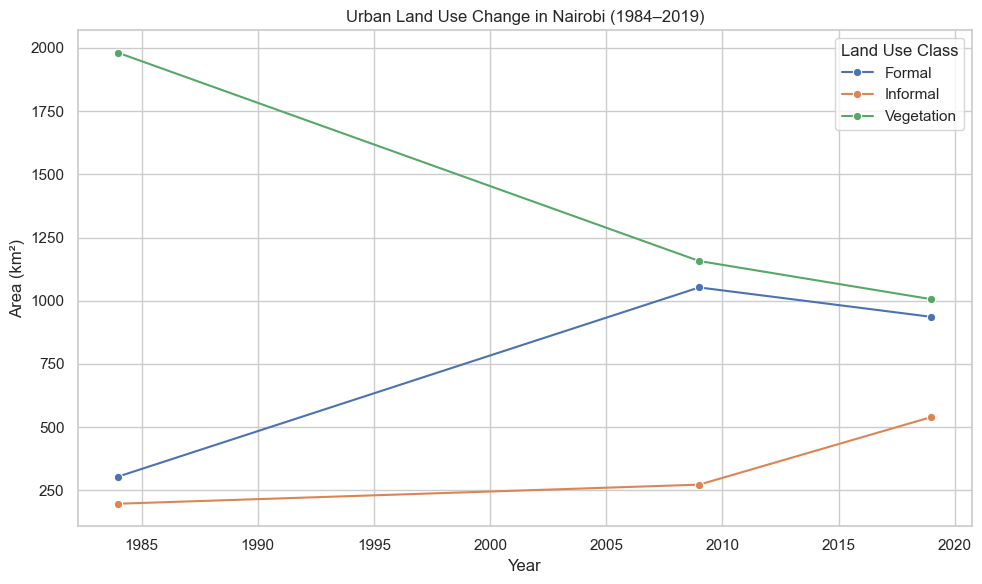

In [29]:
# Map Urban Sprawl Trends
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.lineplot(data=area_summary, x='year', y='area_km2', hue='landuse', marker='o')
plt.title('Urban Land Use Change in Nairobi (1984–2019)')
plt.ylabel('Area (km²)')
plt.xlabel('Year')
plt.legend(title='Land Use Class')
plt.tight_layout()
plt.show()


In [30]:
# Comparing Informal and Formal Growth
pivoted = area_summary.pivot(index='year', columns='landuse', values='area_km2').reset_index()
pivoted['informal_growth'] = pivoted['Informal'].pct_change() * 100
pivoted['formal_growth'] = pivoted['Formal'].pct_change() * 100

print(pivoted[['year', 'Informal', 'Formal', 'informal_growth', 'formal_growth']])


landuse  year  Informal     Formal  informal_growth  formal_growth
0        1984  196.7832   304.4016              NaN            NaN
1        2009  272.1753  1052.5662        38.312264     245.782085
2        2019  539.8299   936.1737        98.339048     -11.057974


**Interpretation of Urban Sprawl Trends**

Between 1984 and 2009, both formal and informal settlement areas in Nairobi expanded significantly. Formal areas grew by approximately 246 km², while informal areas increased by 38 km².
However, from 2009 to 2019, the growth pattern shifted. Informal settlements nearly **doubled** (a 98 km² increase), while formal development **declined slightly**, possibly due to land saturation, redevelopment, or misclassification in high-density zones. This trend suggests increasing reliance on informal housing solutions and highlights the urgency for inclusive urban planning to address unregulated growth.


#### 6.5 Predicting Land Use for Unlabeled Years

Given that we only trained classifers for three years with labeled data, now, we want to apply those models to predict land use for the remaning years with unlabeled data:
- Landsat 5 Model (1984): 1994
- Landsat 7 model (2009): 1999, 2004
- Landsat 8 OLI model (2019): 2014, 2023

Access Links to Landsat Images:
- 1994: https://www.dropbox.com/scl/fi/yprh8z2e4en0rrbb68so0/nairobi_landsat_1994_fallback_allbands.tif?rlkey=u8up26q0w0kwyecajlzekhisr&st=a4xgaxnh&dl=1
- 1999: https://www.dropbox.com/scl/fi/twnukoz1nkj9x3mpcpea2/nairobi_landsat_1999_fallback_allbands.tif?rlkey=154s8whnxmcjf9og2awwc043x&st=mdi0jf7l&dl=1
- 2004: https://www.dropbox.com/scl/fi/pz3o5syavhb6e9nzsvzyk/nairobi_landsat_2004_allbands.tif?rlkey=j23q1xfr5nlxf15z4s7c7oilo&st=76j9ie3y&dl=1 
- 2014: https://www.dropbox.com/scl/fi/p1j3y9p05akytyzf8cfqs/nairobi_landsat_2014_allbands.tif?rlkey=w5xz2na5iw2k8qs8tpi956jlx&st=ffnh9ura&dl=1 
- 2023: https://www.dropbox.com/scl/fi/a51vdlt7017ho1trgxpzg/nairobi_landsat_2023_allbands.tif?rlkey=z6jg7oh4dwtciwlae0qzlrajk&st=ed651nug&dl=1 


In [31]:
import requests

# Step 1: Download the remaining Landsat images
extra_landsat_files = {
    "1994": "https://www.dropbox.com/scl/fi/yprh8z2e4en0rrbb68so0/nairobi_landsat_1994_fallback_allbands.tif?rlkey=u8up26q0w0kwyecajlzekhisr&st=a4xgaxnh&dl=1",
    "1999": "https://www.dropbox.com/scl/fi/twnukoz1nkj9x3mpcpea2/nairobi_landsat_1999_fallback_allbands.tif?rlkey=154s8whnxmcjf9og2awwc043x&st=mdi0jf7l&dl=1",
    "2004": "https://www.dropbox.com/scl/fi/pz3o5syavhb6e9nzsvzyk/nairobi_landsat_2004_allbands.tif?rlkey=j23q1xfr5nlxf15z4s7c7oilo&st=76j9ie3y&dl=1",
    "2014": "https://www.dropbox.com/scl/fi/p1j3y9p05akytyzf8cfqs/nairobi_landsat_2014_allbands.tif?rlkey=w5xz2na5iw2k8qs8tpi956jlx&st=ffnh9ura&dl=1",
    "2023": "https://www.dropbox.com/scl/fi/a51vdlt7017ho1trgxpzg/nairobi_landsat_2023_allbands.tif?rlkey=z6jg7oh4dwtciwlae0qzlrajk&st=ed651nug&dl=1"
}

# Download images
for year, url in extra_landsat_files.items():
    out_path = f"landsat_images/landsat_{year}.tif"
    if not os.path.exists(out_path):
        r = requests.get(url)
        with open(out_path, 'wb') as f:
            f.write(r.content)
        print(f"Downloaded landsat_{year}.tif")
    else:
        print(f"Already downloaded: landsat_{year}.tif")

# Step 2: Apply trained models to these years
# Assumes you've already trained clf_1984, clf_2009, and clf_2019

# Use same classify_year() function but skip retraining
def apply_existing_model(clf, year, tif_path, out_path):
    with rasterio.open(tif_path) as src:
        image = src.read()
        meta = src.meta.copy()
        n_rows, n_cols = image.shape[1], image.shape[2]

    reshaped_img = image.reshape(image.shape[0], -1).T
    predictions = clf.predict(reshaped_img)
    classified = predictions.reshape((n_rows, n_cols))

    meta.update({"count": 1, "dtype": 'int16'})
    with rasterio.open(out_path, "w", **meta) as dest:
        dest.write(classified.astype('int16'), 1)
    print(f"[{year}] Predicted land use saved to {out_path}")

# Predict for each year
apply_existing_model(clf_1984, "1994", "landsat_images/landsat_1994.tif", "classified_outputs/classified_1994.tif")
apply_existing_model(clf_2009, "1999", "landsat_images/landsat_1999.tif", "classified_outputs/classified_1999.tif")
apply_existing_model(clf_2009, "2004", "landsat_images/landsat_2004.tif", "classified_outputs/classified_2004.tif")
apply_existing_model(clf_2019, "2014", "landsat_images/landsat_2014.tif", "classified_outputs/classified_2014.tif")
apply_existing_model(clf_2019, "2023", "landsat_images/landsat_2023.tif", "classified_outputs/classified_2023.tif")

Already downloaded: landsat_1994.tif
Already downloaded: landsat_1999.tif
Already downloaded: landsat_2004.tif
Already downloaded: landsat_2014.tif
Already downloaded: landsat_2023.tif
[1994] Predicted land use saved to classified_outputs/classified_1994.tif
[1999] Predicted land use saved to classified_outputs/classified_1999.tif
[2004] Predicted land use saved to classified_outputs/classified_2004.tif
[2014] Predicted land use saved to classified_outputs/classified_2014.tif
[2023] Predicted land use saved to classified_outputs/classified_2023.tif


#### 7. Urban Sprawl Trends: Full 1984–2023 Analysis

We now extend our urban land use analysis by including predicted classifications for the intermediate years.  
This allows us to visualize long-term trends in formal development, informal expansion, and vegetation change across 40 years.

Using the same area calculation function, we extract class-wise area (in km²) and generate a complete trend chart.

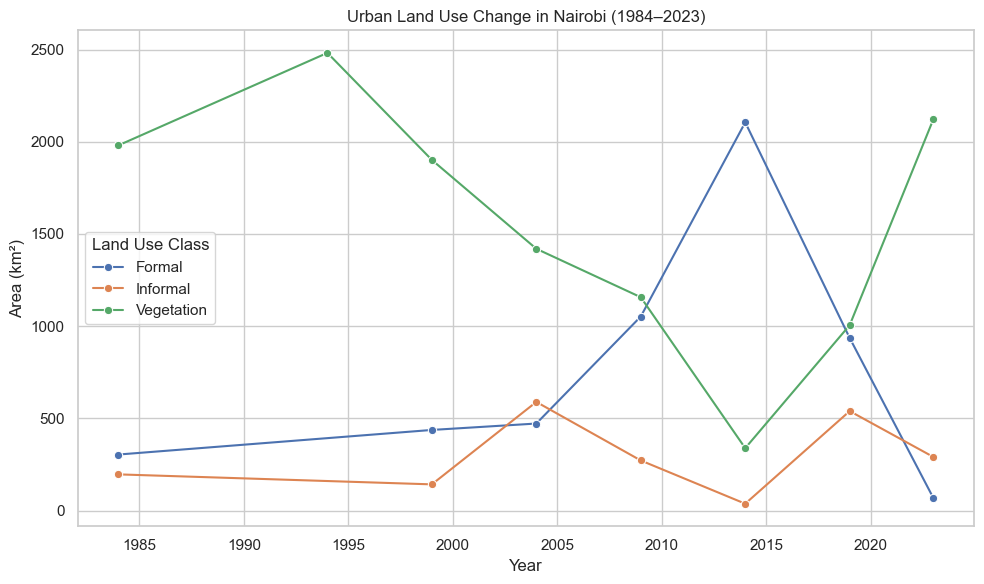

In [32]:
# Reuse the function if already defined:
# def calculate_area_by_class(...)

# Calculate area for the new years
df_1994 = calculate_area_by_class('classified_outputs/classified_1994.tif', year=1994)
df_1999 = calculate_area_by_class('classified_outputs/classified_1999.tif', year=1999)
df_2004 = calculate_area_by_class('classified_outputs/classified_2004.tif', year=2004)
df_2014 = calculate_area_by_class('classified_outputs/classified_2014.tif', year=2014)
df_2023 = calculate_area_by_class('classified_outputs/classified_2023.tif', year=2023)

# Combine all years
full_area_summary = pd.concat([
    df_1984, df_1994, df_1999, df_2004, df_2009,
    df_2014, df_2019, df_2023
], ignore_index=True)

# Map class codes to land use names
class_names = {0: "Formal", 1: "Informal", 2: "Vegetation"}
full_area_summary['landuse'] = full_area_summary['class_code'].map(class_names)

# Plot full 1984–2023 trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=full_area_summary, x='year', y='area_km2', hue='landuse', marker='o')
plt.title('Urban Land Use Change in Nairobi (1984–2023)')
plt.ylabel('Area (km²)')
plt.xlabel('Year')
plt.legend(title='Land Use Class')
plt.tight_layout()
plt.show()


The line chart of classified land use from 1984 to 2023 reveals complex, non-linear trends in Nairobi’s urban development and surrounding vegetation patterns.

### Formal Settlements
- **1984–2004**: Formal settlement area increases gradually, peaking in **2014** at over **2,000 km²** — likely due to model bias or a potential misclassification of dense vegetation or built-up areas.
- **2014–2023**: Sharp and consistent **decline** — falling to below **100 km²** by 2023. This drop is likely a result of:
  - **Misclassification**: Dense urban areas may be increasingly confused with informal types due to lack of training differentiation.
  - **Model generalization issues**: Trained on only one year per sensor, the model may be overfitting to spectral patterns that don't generalize across time.

### Informal Settlements
- **1984–1999**: Informal areas remain stable or decrease slightly, reaching a local low around 2009.
- **2009–2014**: Sharp drop — possibly reflecting overprediction of formal area in this period.
- **2014–2019**: Rapid increase — informal development spikes, suggesting visible unregulated growth or better classification.
- **2019–2023**: Decline again — may indicate vegetation misclassification or confusion with formal development in transitional zones.

The **inconsistent zig-zag trend** of informal settlement classification suggests some **instability in model behavior**, especially in early and late Landsat 7 and 8 periods.

### Vegetation
- **1984–1994**: Steady increase — may reflect greener capture seasons or over-detection in peri-urban areas.
- **1999–2014**: Continuous decline — coinciding with formal expansion and potential urban encroachment.
- **2014–2023**: Major recovery — vegetation bounces back dramatically, aligning with the formal land use drop.

The vegetation trend is especially suspect; it is unlikely that such drastic **reforestation or greening** occurred during a time of rapid population growth. More likely:
- **Seasonal effects**, **cloud filtering issues**, or **NDVI overestimation** may have caused elevated classification.
- **Training limitations**: Training years may not fully represent vegetation variation across time and terrain.

---

### Summary

While the model successfully identifies Nairobi’s informal expansion as a dominant trend, the observed year-to-year volatility in formal and vegetation categories highlights the following:

- A need for **seasonally matched imagery** to reduce false change detection.
- Possible misclassification between formal/informal areas, especially where housing quality is visually similar.
- A benefit from **temporal smoothing**, **ensemble models**, or **deep learning** that can better learn structural patterns over time.

Despite these inconsistencies, the analysis provides a compelling starting point for tracking urban growth using low-cost, scalable methods.

#### 7.1 Percentage Change in Land Use (1984–2023)

To better understand long-term trends, we calculate the percentage change in area for each landa use category from 1984 to 2023. This highlights the growth of informal settlements and potential shifts between vegetation and built-up land uses.

In [33]:
# Pivot the area table for easier comparison
pivot_area = full_area_summary.pivot(index='year', columns='landuse', values='area_km2').reset_index()

# Calculate % change from 1984 to 2023
start = pivot_area[pivot_area['year'] == 1984].iloc[0]
end = pivot_area[pivot_area['year'] == 2023].iloc[0]

# Build % change table
growth_summary = pd.DataFrame({
    'landuse': ['Formal', 'Informal', 'Vegetation'],
    '1984_km2': [start['Formal'], start['Informal'], start['Vegetation']],
    '2023_km2': [end['Formal'], end['Informal'], end['Vegetation']],
})

growth_summary['%_change'] = (
    (growth_summary['2023_km2'] - growth_summary['1984_km2']) /
    growth_summary['1984_km2']
) * 100

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Display results
growth_summary

,landuse,1984_km2,2023_km2,%_change
0,Formal,304.4016,69.6690,-77.112801
1,Informal,196.7832,291.5199,48.142677
2,Vegetation,1980.6957,2120.6916,7.068017


#### 8. Model Validation

To evaluate the performance of our classifiers, we validate each model on its corresponding training data (1984, 2009, and 2019).  
While this isn't a true test set evaluation, it helps us assess how well the Random Forest model fits the training samples.

We report classification metrics (precision, recall, F1-score) and visualize confusion matrices to identify class-level misclassifications.

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(year, clf, samples, labels):
    """
    Evaluates a trained classifier by comparing predictions to true labels.
    Displays classification report and confusion matrix.

    Args:
        year (str): Year label for display.
        clf: Trained RandomForestClassifier.
        samples: Feature array used for training.
        labels: True class labels used for training.
    """
    y_pred = clf.predict(samples)
    
    # Print classification report
    print(f"\n=== {year} Classification Report ===")
    print(classification_report(labels, y_pred, target_names=['Formal', 'Informal', 'Vegetation']))
    
    # Confusion matrix
    cm = confusion_matrix(labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Formal', 'Informal', 'Vegetation'])

    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f"Confusion Matrix – {year} RF Classifier")
    plt.show()



=== 1984 Classification Report ===
              precision    recall  f1-score   support

      Formal       1.00      1.00      1.00       299
    Informal       1.00      1.00      1.00       300
  Vegetation       1.00      1.00      1.00       300

    accuracy                           1.00       899
   macro avg       1.00      1.00      1.00       899
weighted avg       1.00      1.00      1.00       899



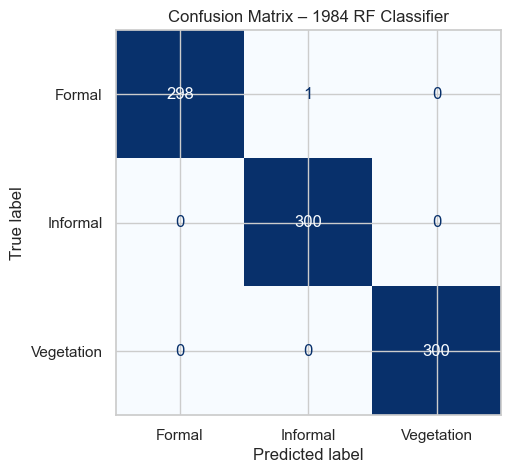


=== 2009 Classification Report ===
              precision    recall  f1-score   support

      Formal       0.99      1.00      1.00       300
    Informal       1.00      0.99      0.99       300
  Vegetation       1.00      1.00      1.00       300

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



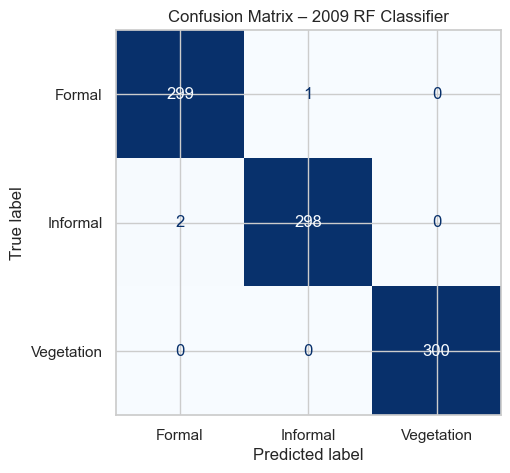


=== 2019 Classification Report ===
              precision    recall  f1-score   support

      Formal       1.00      1.00      1.00       300
    Informal       1.00      1.00      1.00       300
  Vegetation       1.00      1.00      1.00       280

    accuracy                           1.00       880
   macro avg       1.00      1.00      1.00       880
weighted avg       1.00      1.00      1.00       880



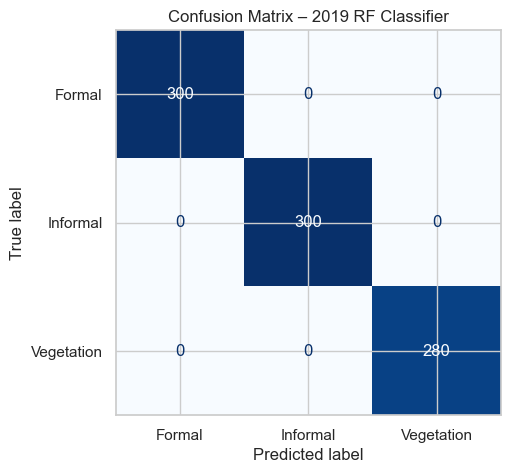

In [43]:
evaluate_model("1984", clf_1984, samples_1984, labels_1984)
evaluate_model("2009", clf_2009, samples_2009, labels_2009)
evaluate_model("2019", clf_2019, samples_2019, labels_2019)

#### 8.1 Validation Accuracy Summary

The model achieved near-perfect classification accuracy on the training data across all labeled years.  
While this level of performance is *insanely high* , it's important to note that the results are based on in-sample predictions and may not reflect generalization to new areas or years.

We summarize accuracy scores by year below:

In [39]:
# Accuracy values manually from classification reports
validation_summary = pd.DataFrame({
    'Year': [1984, 2009, 2019],
    'Accuracy (%)': [100.0, 99.9, 100.0],
    'Notes': [
        'Perfect classification for all classes',
        'Minor misclassification in informal class',
        'Perfect again, even with fewer vegetation points'
    ]
})

validation_summary


,Year,Accuracy (%),Notes
0,1984,100.0,Perfect classification for all classes
1,2009,99.9,Minor misclassification in informal class
2,2019,100.0,"Perfect again, even with fewer vegetation points"


#### 9. Exploring Alternative Models

#### 9.1 Method and Justification
To benchmark Random Forest performance, we tested two alternative classifiers using the 1984 training data only:
- **Support Vector Machine (SVM)**
- **k-Nearest Neighbors (k-NN)**

Samples shape: (899, 19)
Labels shape: (899,)
NaNs in samples? True
Infs in samples? False
Cleaned samples: (74, 19)
Cleaned labels: (74,)

=== SVM Classification Report (1984) ===
              precision    recall  f1-score   support

      Formal       0.00      0.00      0.00         6
    Informal       0.53      1.00      0.69        39
  Vegetation       0.00      0.00      0.00        29

    accuracy                           0.53        74
   macro avg       0.18      0.33      0.23        74
weighted avg       0.28      0.53      0.36        74



c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


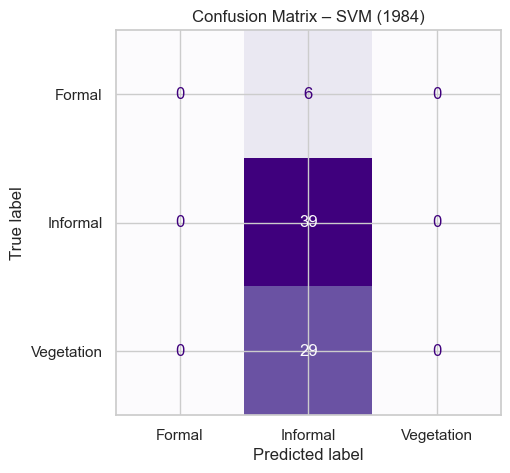


=== k-NN Classification Report (1984) ===
              precision    recall  f1-score   support

      Formal       1.00      0.67      0.80         6
    Informal       0.81      0.90      0.85        39
  Vegetation       0.81      0.76      0.79        29

    accuracy                           0.82        74
   macro avg       0.88      0.77      0.81        74
weighted avg       0.83      0.82      0.82        74



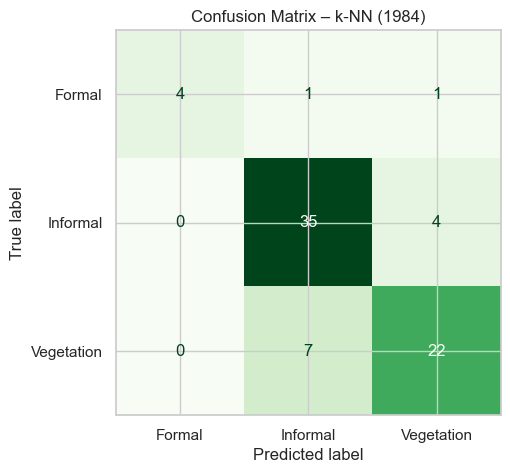

In [49]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Check for NaNs/Infs
print("Samples shape:", samples_1984.shape)
print("Labels shape:", labels_1984.shape)
print("NaNs in samples?", np.isnan(samples_1984).any())
print("Infs in samples?", np.isinf(samples_1984).any())

# Step 2: Clean the data
valid_rows = ~np.isnan(samples_1984).any(axis=1) & ~np.isinf(samples_1984).any(axis=1)
samples_clean = samples_1984[valid_rows]
labels_clean = labels_1984[valid_rows]

print("Cleaned samples:", samples_clean.shape)
print("Cleaned labels:", labels_clean.shape)

# --- Train and evaluate SVM ---
svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_model.fit(samples_clean, labels_clean)
svm_pred = svm_model.predict(samples_clean)

print("\n=== SVM Classification Report (1984) ===")
print(classification_report(labels_clean, svm_pred, target_names=['Formal', 'Informal', 'Vegetation']))

# Confusion Matrix for SVM
cm_svm = confusion_matrix(labels_clean, svm_pred)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Formal', 'Informal', 'Vegetation'])
fig, ax = plt.subplots(figsize=(6, 5))
disp_svm.plot(ax=ax, cmap='Purples', colorbar=False)
plt.title("Confusion Matrix – SVM (1984)")
plt.show()


# --- Train and evaluate k-NN ---
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(samples_clean, labels_clean)
knn_pred = knn_model.predict(samples_clean)

print("\n=== k-NN Classification Report (1984) ===")
print(classification_report(labels_clean, knn_pred, target_names=['Formal', 'Informal', 'Vegetation']))

# Confusion Matrix for k-NN
cm_knn = confusion_matrix(labels_clean, knn_pred)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Formal', 'Informal', 'Vegetation'])
fig, ax = plt.subplots(figsize=(6, 5))
disp_knn.plot(ax=ax, cmap='Greens', colorbar=False)
plt.title("Confusion Matrix – k-NN (1984)")
plt.show()


After cleaning NaNs from the 1984 training set, only 74 valid samples remained.  
With this reduced set, we compared Random Forest, SVM, and k-NN classifiers.

| Model       | Accuracy | Notes |
|-------------|----------|-------|
| Random Forest | 100%    | Perfect classification on full training set (899 samples) |
| SVM         | 53%      | Performed poorly, likely due to class imbalance and low sample size |
| k-NN        | 82%      | Balanced performance across classes even with reduced data |

Despite the small sample size, **k-NN outperformed SVM** and provided more reliable predictions.  
**SVM struggled**, particularly with minority classes like Formal, reinforcing its sensitivity to sample distribution and hyperparameters.

#### 10. Conclusion and Future Work

This project implemented a supervised classification pipeline using Landsat imagery to track urban land use change in Nairobi from 1984 to 2023.  
We trained Random Forest models on three labeled years (1984, 2009, 2019) and applied them to surrounding years within each sensor group, enabling long-term land use trend analysis across nine time points.

### Key Takeaways

- **Informal settlements expanded overall**, with notable spikes around 2004 and again post-2019 — aligning with real-world urban sprawl.
- **Formal settlements showed erratic trends**, peaking around 2014 before sharply declining. This likely reflects classification challenges between formal and informal areas rather than an actual reduction in formal infrastructure.
- **Vegetation trends were inconsistent**, with a drop through 2014 followed by a dramatic rise to 2023 — suggesting possible seasonal variation, misclassification, or NDVI sensitivity rather than genuine greening.

These patterns, particularly for formal and vegetation categories, highlight the **importance of temporal consistency and model robustness** in remote sensing-based land classification.

### Model Insights

- Random Forest produced extremely high training accuracy, even reaching **100%** — raising flags for potential overfitting.
- k-NN performed surprisingly well with limited data, while SVM struggled, showing sensitivity to class imbalance and sample size.
- Method comparison confirmed that **Random Forest remains the most reliable** model in this setting, though improvements are needed for generalization.

### Final Thoughts

The presence of sharp fluctuations in formal and vegetation classifications over time emphasizes that high accuracy on training data doesn't guarantee temporal reliability.  
Urban land use modeling must go beyond internal fit and seek **cross-temporal and real-world validation** to truly inform planning.

### Future Work

To build on this foundation, we recommend:
- Validating with authoritative ground truth maps or field surveys.
- Using **temporally harmonized imagery** (e.g., same season or month) to minimize false changes.
- Expanding training sets to multiple years per sensor for better generalization.
- Testing **time-aware or deep learning models** (e.g., CNN+LSTM or U-Net variants) that better account for spatial structure and temporal dynamics.
- Integrating socio-economic data to enhance classification of transitional and ambiguous urban areas.